# Double Jet

With various grid sizes

In [1]:
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

# plt.style.use('dark_background')

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.DoubleJetPlot import *

Get initial arguments from class

In [4]:
from gpuocean.utils import DoubleJetCase

In [5]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [6]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-11-02T09_33_29"

true_state = np.load(os.path.join(truth_path, "truth_864000.npy"))

(<Figure size 1500x1000 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

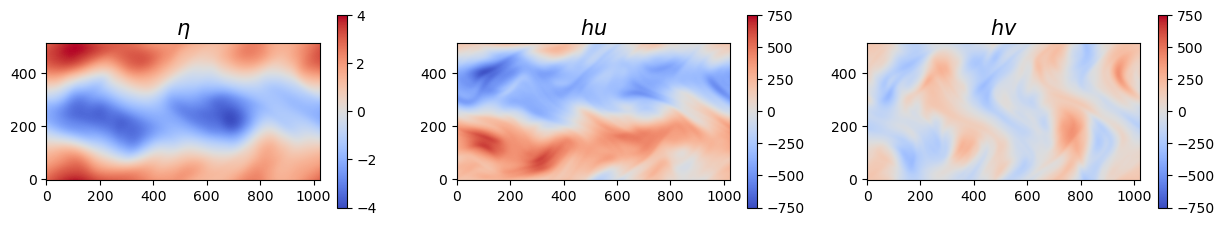

In [7]:
imshow3(true_state, eta_vlim=4)

## Ensembles

In [8]:
from utils.DoubleJetSL import *

In [9]:
def MLestimator(ML_state, func, **kwargs):
    numLevels = len(ML_state)
    MLest = np.zeros(ML_state[-1][0].shape[:-1])
    MLest += func(ML_state[0], axis=-1, **kwargs).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2)
    for l_idx in range(1, numLevels):
        MLest += (func(ML_state[l_idx][0], axis=-1, **kwargs) - func(ML_state[l_idx][1], axis=-1, **kwargs).repeat(2,1).repeat(2,2)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2)
    return MLest

In [10]:
def plot_MLstates(ml_state):
    from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
    from mpl_toolkits.axes_grid1.colorbar import colorbar

    from gpuocean.ensembles import MultiLevelOceanEnsemble
    fig, axs = plt.subplots(3,3, figsize=(20,15))

    def _add_cb(ax, im, label=None):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(label)


    ML_mean = MLestimator(ml_state, np.mean)
    vlims = [4, 750, 750]
    for i in range(3):
        im = axs[0,i].imshow(ML_mean[i], cmap=plt.cm.coolwarm, vmin=-vlims[i], vmax=vlims[i])
        _add_cb(axs[0,i], im)

    ML_std = MLestimator(ml_state, np.std, ddof=1)
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[1,i].imshow(ML_std[i], cmap=plt.cm.Oranges, vmin=0, vmax=vlims[i])
        _add_cb(axs[1,i], im)

    ML_err = np.abs(ML_mean - true_state) 
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[2,i].imshow(ML_err[i], cmap=plt.cm.Reds, vmin=0, vmax=vlims[i])
        _add_cb(axs[2,i], im)

In [11]:
def ML_from_path(mlda_path): 

    ML_state = []
    ML_state.append(np.load(mlda_path+"/MLstates/MLensemble_0.npy"))

    numLevels = len(set([f.split("_")[1][0] for f in os.listdir(mlda_path+"/MLstates")]))
    for l_idx in range(1, numLevels):
        ML_state.append( [np.load(mlda_path+"/MLstates/MLensemble_"+str(l_idx)+"_0.npy"), np.load(mlda_path+"/MLstates/MLensemble_"+str(l_idx)+"_1.npy")] )

    return ML_state

In [12]:
mlda0_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-08T16_32_29"
ML0_state = ML_from_path(mlda0_path)

In [13]:
mlda1_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-13T14_29_01"
ML1_state = ML_from_path(mlda1_path)

In [14]:
def MLMSE(ML_state, true_state):
    numLevels = len(ML_state)
    MLest = np.zeros(ML_state[-1][0].shape[:-1])
    MLest += np.mean((ML_state[0].repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2) - true_state[:,:,:,np.newaxis])**2, axis=-1) 
    for l_idx in range(1, numLevels):
        MLest += np.mean((ML_state[l_idx][0].repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2) - true_state[:,:,:,np.newaxis])**2
                          - (ML_state[l_idx][1].repeat(2**(numLevels-l_idx),1).repeat(2**(numLevels-l_idx),2) - true_state[:,:,:,np.newaxis])**2,
                          axis=-1)
    return np.sqrt(np.maximum(0,MLest))

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  


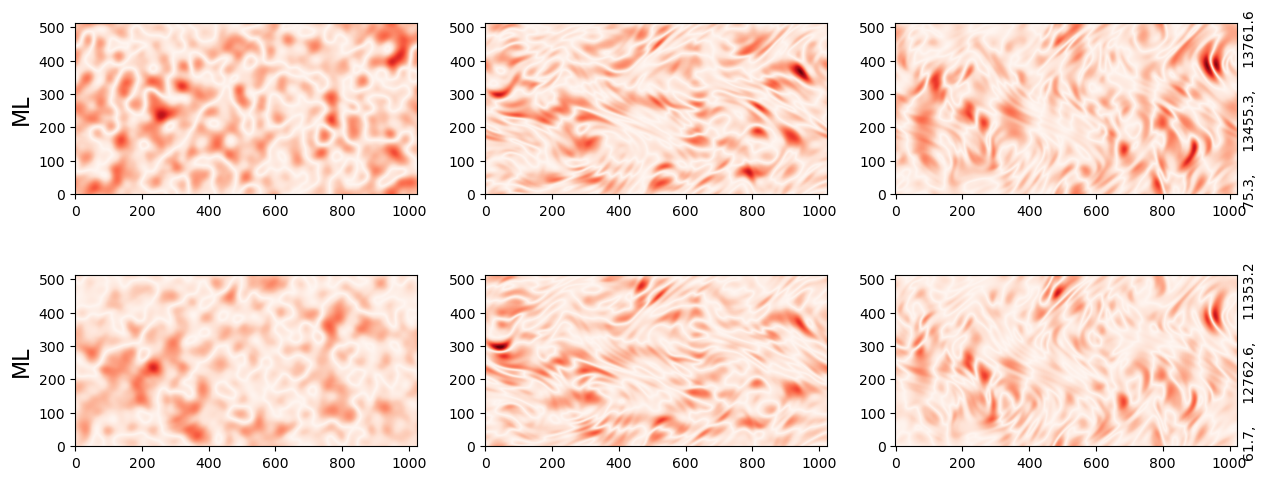

In [15]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

fig, axs = plt.subplots(2,3, figsize=(15,6))

def _add_cb(ax, im, label=None):
    ax_divider = make_axes_locatable(ax)
    ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
    cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
    ax_cb.xaxis.set_ticks_position("top")
    ax_cb.set_title(label)

vlims=[0.5, 100, 100]
def _plot3(axs, state, cbar=False):
    for i in range(3):
        im = axs[i].imshow(state[i], cmap=plt.cm.Reds, vmin=0, vmax=vlims[i])
        if cbar:
            _add_cb(axs[i], im)
    axs[2].yaxis.set_label_position("right")
    axs[2].set_ylabel(",     ".join(["{:.1f}".format(v) for v in np.linalg.norm(state, axis=(1,2))]), fontsize=10)


axs[0,0].set_ylabel("ML", fontsize=16)
ML0_err = np.abs(MLestimator(ML0_state, np.mean) - true_state)
_plot3(axs[0], ML0_err) 

axs[1,0].set_ylabel("ML", fontsize=16)
ML1_err = np.abs(MLestimator(ML1_state, np.mean) - true_state)
_plot3(axs[1], ML1_err) 


In [16]:
Ts = np.arange(0, 13*24*3600, 900)/(24*3600)

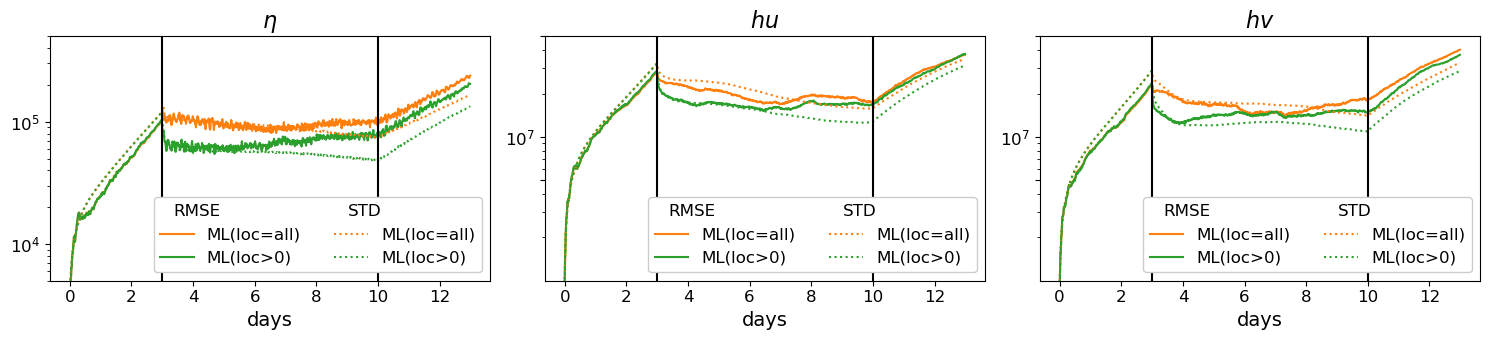

In [17]:
fig, axs = plt.subplots(1,3, figsize=(15,3.5))

ml0_rmse = np.load(mlda0_path + "/MLrmses_posterior.npy")
ml1_rmse = np.load(mlda1_path + "/MLrmses_posterior.npy")

ml0_std = np.load(mlda0_path + "/MLstddevs_posterior.npy")
ml1_std = np.load(mlda1_path + "/MLstddevs_posterior.npy")

for i in range(3):
    axs[i].set_yscale("log")

    axs[i].plot(Ts, ml0_rmse[:,i], c="C1",  label="ML(loc=all)")
    axs[i].plot(Ts, ml1_rmse[:,i], c="C2",  label="ML(loc>0)")

    axs[i].plot(Ts, ml0_std[:,i], c="C1", ls="dotted", label="ML(loc=all)")
    axs[i].plot(Ts, ml1_std[:,i], c="C2", ls="dotted", label="ML(loc>0)")

    axs[i].axvline(3, c="black")
    axs[i].axvline(10, c="black")

    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xlabel("days", fontsize=14)
    
    if i == 0:
        axs[i].set_ylim((5e3, 5e5))
    else:
        axs[i].set_ylim((1e6, 5e7))
        axs[i].set_yticks([5e6, 1e7, 5e7])
        plt.setp(axs[i].get_yminorticklabels(), visible=False)


    # https://stackoverflow.com/questions/44071525/matplotlib-add-titles-to-the-legend-rows
    h, l = axs[i].get_legend_handles_labels()
    ph = [plt.plot([],marker="", ls="")[0]]*2

    handles = ph[:1] + h[:2] + ph[1:] + h[2:]
    labels = ["RMSE"] + l[:2] + ["STD"] + l[2:]


    leg = axs[i].legend(handles, labels, loc=4, ncol=2, framealpha=1.0, fontsize=12)

    for vpack in leg._legend_handle_box.get_children():
        for hpack in vpack.get_children()[:1]:
            hpack.get_children()[0].set_width(0)

axs[0].set_title(r"$\eta$", fontsize=16)
axs[1].set_title(r"$hu$", fontsize=16)
axs[2].set_title(r"$hv$", fontsize=16)

plt.tight_layout()

# plt.savefig("DoubleJet-DA-PostProcessing-States-FixedTau.pdf", bbox_inches="tight", dpi=300)

Comparing against different realisations!

- Same truth
- Same ensemble size

In [22]:
def Ne_from_ML(ML_state):
    Ne = []
    Ne.append(ML_state[0].shape[-1])
    for l_idx in range(1, len(ML_state)):
        Ne.append(ML_state[l_idx][0].shape[-1])
    return Ne 

In [23]:
mlda0_path2 = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-09T18_07_14"

In [25]:
Ne_from_ML(ML0_state), Ne_from_ML(ML_from_path(mlda0_path2))

([275, 134, 46, 13], [275, 134, 46, 13])

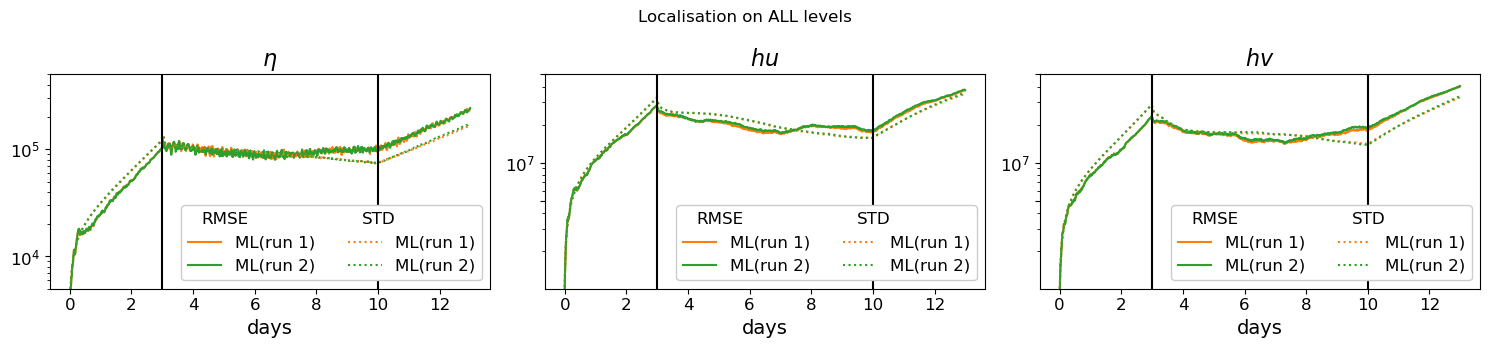

In [29]:
fig, axs = plt.subplots(1,3, figsize=(15,3.5))

ml0_rmse2 = np.load(mlda0_path2 + "/MLrmses_posterior.npy")
ml0_std2 = np.load(mlda0_path2 + "/MLstddevs_posterior.npy")

for i in range(3):
    axs[i].set_yscale("log")

    axs[i].plot(Ts, ml0_rmse[:,i], c="C1",  label="ML(run 1)")
    axs[i].plot(Ts, ml0_rmse2[:,i], c="C2",  label="ML(run 2)")

    axs[i].plot(Ts, ml0_std[:,i], c="C1", ls="dotted", label="ML(run 1)")
    axs[i].plot(Ts, ml0_std2[:,i], c="C2", ls="dotted", label="ML(run 2)")

    axs[i].axvline(3, c="black")
    axs[i].axvline(10, c="black")

    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xlabel("days", fontsize=14)
    
    if i == 0:
        axs[i].set_ylim((5e3, 5e5))
    else:
        axs[i].set_ylim((1e6, 5e7))
        axs[i].set_yticks([5e6, 1e7, 5e7])
        plt.setp(axs[i].get_yminorticklabels(), visible=False)


    # https://stackoverflow.com/questions/44071525/matplotlib-add-titles-to-the-legend-rows
    h, l = axs[i].get_legend_handles_labels()
    ph = [plt.plot([],marker="", ls="")[0]]*2

    handles = ph[:1] + h[:2] + ph[1:] + h[2:]
    labels = ["RMSE"] + l[:2] + ["STD"] + l[2:]


    leg = axs[i].legend(handles, labels, loc=4, ncol=2, framealpha=1.0, fontsize=12)

    for vpack in leg._legend_handle_box.get_children():
        for hpack in vpack.get_children()[:1]:
            hpack.get_children()[0].set_width(0)

axs[0].set_title(r"$\eta$", fontsize=16)
axs[1].set_title(r"$hu$", fontsize=16)
axs[2].set_title(r"$hv$", fontsize=16)

fig.suptitle("Localisation on ALL levels")

plt.tight_layout()

In [19]:
mlda1_path2 = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-15T14_11_56"

In [26]:
Ne_from_ML(ML1_state), Ne_from_ML(ML_from_path(mlda1_path2))

([275, 134, 46, 13], [275, 134, 46, 13])

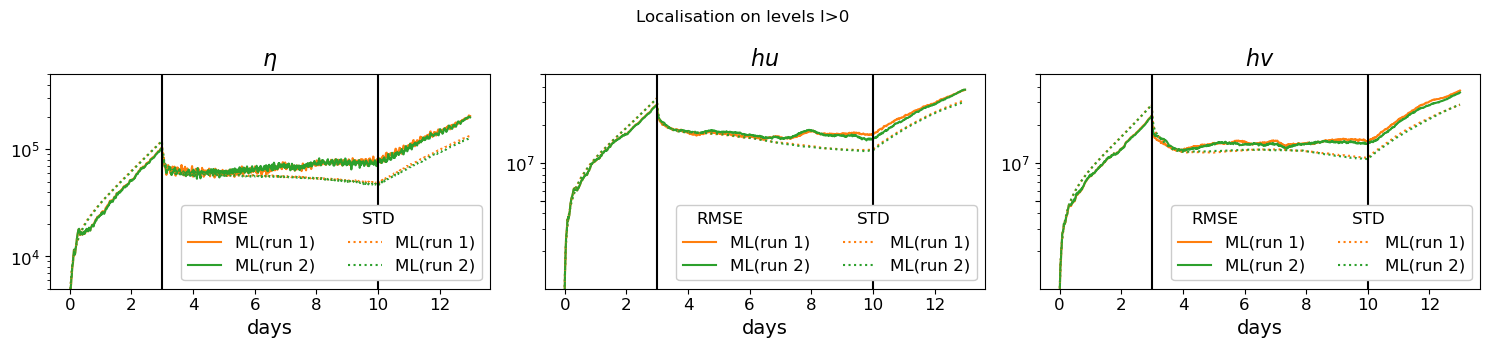

In [30]:
fig, axs = plt.subplots(1,3, figsize=(15,3.5))

ml1_rmse2 = np.load(mlda1_path2 + "/MLrmses_posterior.npy")
ml1_std2 = np.load(mlda1_path2 + "/MLstddevs_posterior.npy")

for i in range(3):
    axs[i].set_yscale("log")

    axs[i].plot(Ts, ml1_rmse[:,i], c="C1",  label="ML(run 1)")
    axs[i].plot(Ts, ml1_rmse2[:,i], c="C2",  label="ML(run 2)")

    axs[i].plot(Ts, ml1_std[:,i], c="C1", ls="dotted", label="ML(run 1)")
    axs[i].plot(Ts, ml1_std2[:,i], c="C2", ls="dotted", label="ML(run 2)")

    axs[i].axvline(3, c="black")
    axs[i].axvline(10, c="black")

    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xlabel("days", fontsize=14)
    
    if i == 0:
        axs[i].set_ylim((5e3, 5e5))
    else:
        axs[i].set_ylim((1e6, 5e7))
        axs[i].set_yticks([5e6, 1e7, 5e7])
        plt.setp(axs[i].get_yminorticklabels(), visible=False)


    # https://stackoverflow.com/questions/44071525/matplotlib-add-titles-to-the-legend-rows
    h, l = axs[i].get_legend_handles_labels()
    ph = [plt.plot([],marker="", ls="")[0]]*2

    handles = ph[:1] + h[:2] + ph[1:] + h[2:]
    labels = ["RMSE"] + l[:2] + ["STD"] + l[2:]


    leg = axs[i].legend(handles, labels, loc=4, ncol=2, framealpha=1.0, fontsize=12)

    for vpack in leg._legend_handle_box.get_children():
        for hpack in vpack.get_children()[:1]:
            hpack.get_children()[0].set_width(0)

axs[0].set_title(r"$\eta$", fontsize=16)
axs[1].set_title(r"$hu$", fontsize=16)
axs[2].set_title(r"$hv$", fontsize=16)

fig.suptitle("Localisation on levels l>0 ")

plt.tight_layout()